# Using Natural Language Processing to predict suicidal ideation on Reddit

## Introduction
Suicide is one of the leading causes of death globally, with an estimate of 800,000 annually. That is one person every 40 seconds (WHO, 2014). A key aspect in suicide prevention is addressing suicidal thoughts before they become actions. With an ever increasing number of internet, social media platforms have become a space where people share about their daily lives, and this include emotions and hardships. A recent US study has shown a strong positive correlation between the proportion of the tweets containing suicide risk factors with rates of age-adjusted suicide rates in the US. This means that even suicidal thoughts are posted in social media platforms. 

In this analysis, we use multiple techniques of natural language processing to classify suicidal and non-suicidal thoughts. We then compare the techniques to decide which one performs better. 

## About the data
In this notebook, we used the data collected from Reddit's "SuicideWatch" and "teenagers" subreddits using PushShift API. The data collected is from December 16, 2008 to January 1, 2021. Please find the dataset [here](https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/MyDrive/Colab\ Notebooks/utils.py /content/
!cp /content/drive/MyDrive/Colab\ Notebooks/Suicide_Detection.csv /content/

# !pip install contractions
# !pip install langdetect

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup

In [2]:
# Import libraries and helper functions
import warnings
warnings.filterwarnings('ignore')
from utils import *

In [3]:
# Read in data
# data_path = "~/Desktop/Work/Github/_data/Suicide_Detection.csv"
data_path = "/content/Suicide_Detection.csv"
reddit_data = pd.read_csv(data_path, index_col = 0).reset_index(drop=True)
reddit_data.sample(5, random_state= 1)  # peak at a random sample of 5 rows

,text,class
79689,I want to go to sleep and never wake upMy reas...,suicide
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide
226306,the sun is setting and it's raining i'm curren...,non-suicide
101296,Hi. Im scared. Plz talk to me.Private message,suicide
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [4]:
reddit_data.info()      # data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    232074 non-null  object
 1   class   232074 non-null  object
dtypes: object(2)
memory usage: 3.5+ MB


The dataset has two columns, both in correct data types and there are no missing values.

## Initial Text Analysis

### Distribution of target variable classes

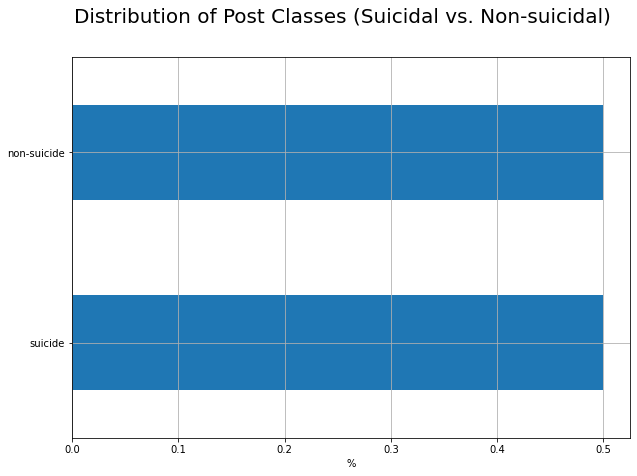

In [5]:
# Evaluate distribution of post classes (target variable)
plot_distributions(data=reddit_data, x="class", figsize=(10,7), title= "Distribution of Post Classes (Suicidal vs. Non-suicidal)", 
                    xlabel="%", normalize=True)

The target variable is perfectly balanced, meaning 50% are suicidal posts while the other half is not. 

In [6]:
reddit_data = reddit_data.sample(frac=0.01, random_state=1)

### Name Entity Recognition (NER)

Additionally, Name Entity Recognition will be done below to extract more features and understand which ones are more common in reddit posts

In [7]:
%%bash
python -m spacy download en_core_web_lg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [8]:
# only select a few list of tags
tags_list = ["ORG","PERSON","NORP","GPE","LOC","FAC","EVENT","PRODUCT","WORK_OF_ART"]
# use spacy's NER model for news, comments, blogs
model = spacy.load("en_core_web_lg")
# append tags to dataset
reddit_data = add_ner_spacy(dtf = reddit_data, column = "text", lst_tag_filter = tags_list, create_features=True)

--- tagging ---


  0%|          | 0/2321 [00:00<?, ?it/s]

--- counting tags ---


  0%|          | 0/2321 [00:00<?, ?it/s]

--- creating features ---


  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

In [9]:
# make sure tags were created
reddit_data.head()

,text,class,text_tagged,tags,tags_WORK_OF_ART,tags_FAC,tags_GPE,tags_NORP,tags_PRODUCT,tags_EVENT,tags_LOC,tags_ORG,tags_PERSON
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...","[{('YO', 'ORG'): 1}, {('https://www.webtoons.c...",0,0,0,0,0,0,0,2,0
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",0,0,0,0,0,0,0,1,0
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Reddit', 'ORG'): 1}]",0,0,0,0,0,0,0,1,0


Class: suicide


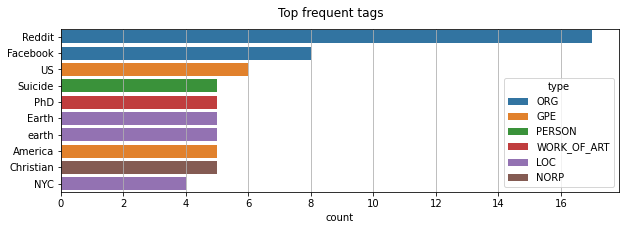

Class: non-suicide


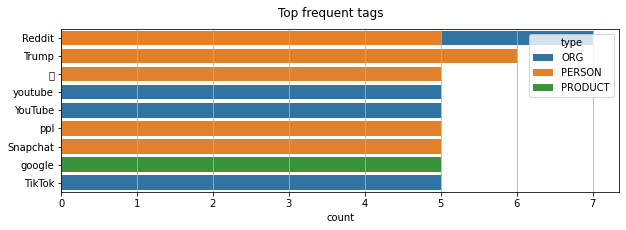

In [10]:
# Visualize tags by class
for label in reddit_data["class"].unique():
    print(f"Class: {label}")
    common_tags = plot_tags(tags=reddit_data[reddit_data["class"]== label]["tags"], top=10, figsize=(10,3))

COMMENT: Remove Reddit, idk

There seem to be no difference between the tags from suicidal and non suicidal posts for text before processing the posts. As expected Reddit comes in very often along with America and US. It looks like non-suicidal posts have more political conversations (Trump, Biden) while the suicidal posts seem to be focused on living daily life (e.g. Christian, University, NYC, UK, etc...)

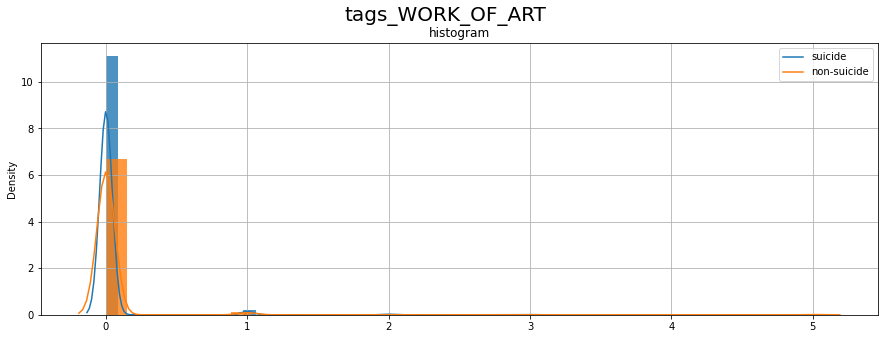

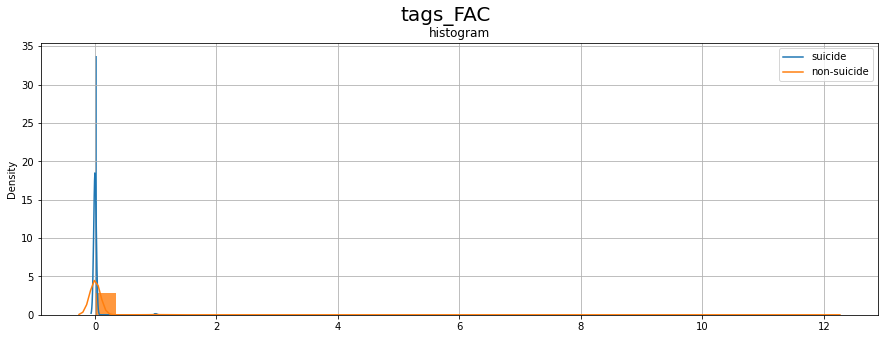

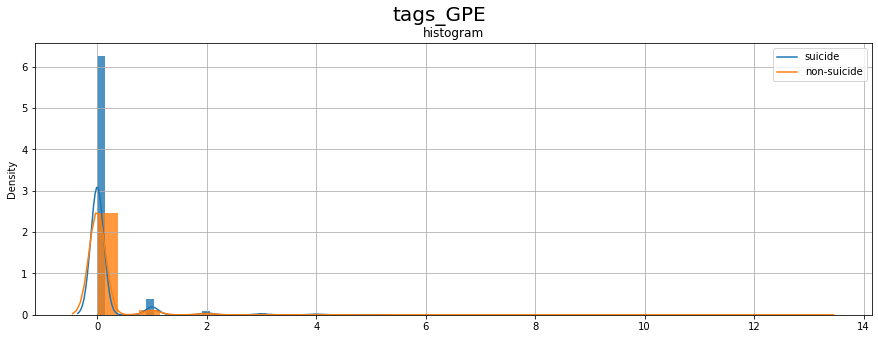

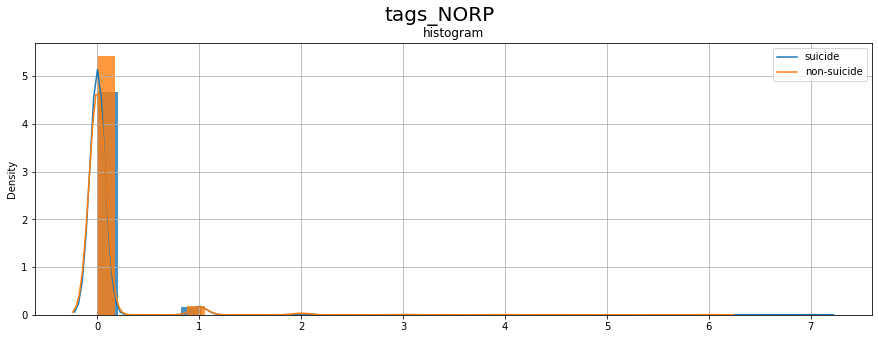

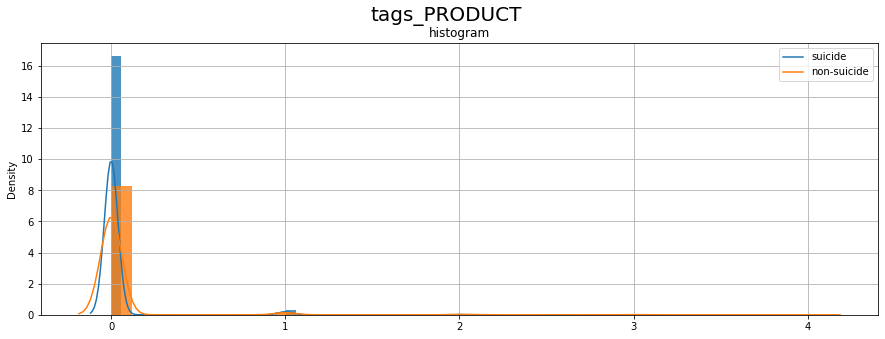

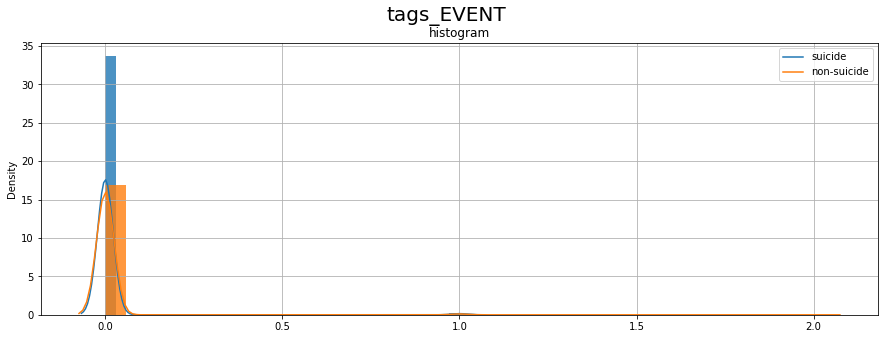

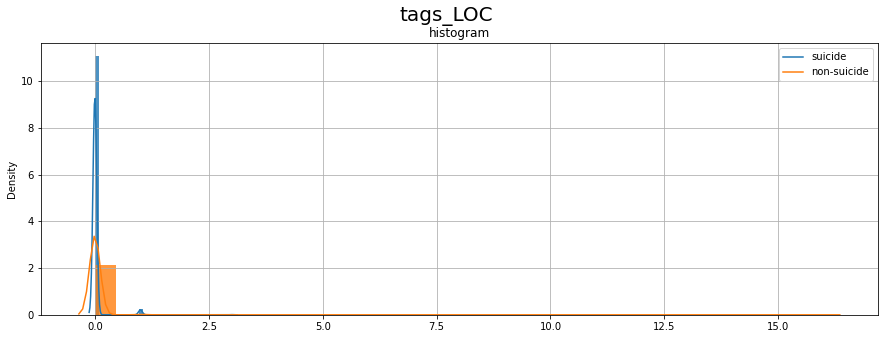

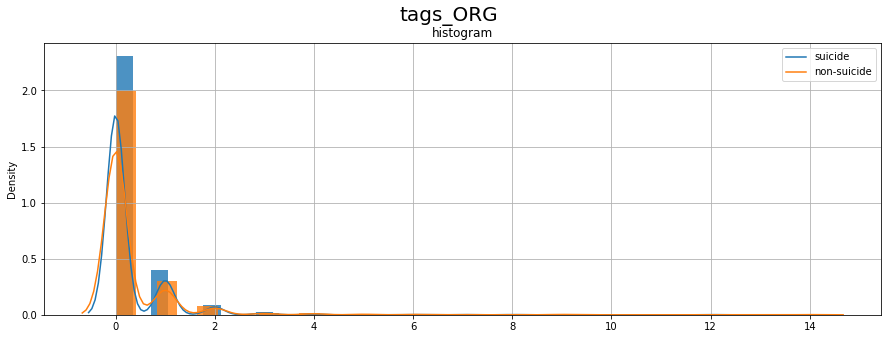

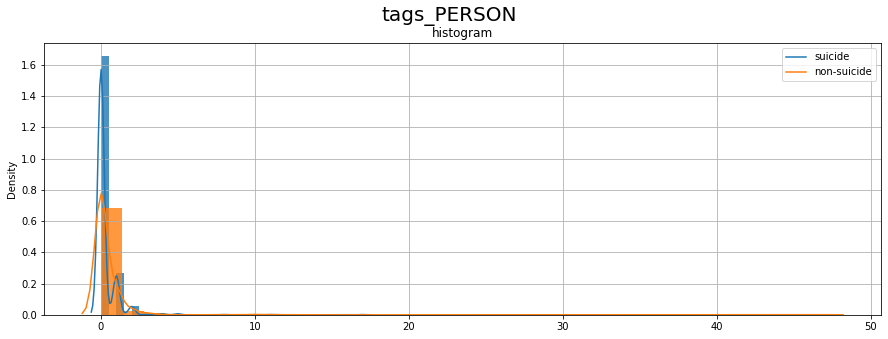

In [11]:
for x in reddit_data.filter(like="tags_", axis=1).columns:
    plot_distributions(reddit_data, x= x, y="class", bins=None, figsize=(15,5))

### Extract more text characteristics
Features to be extracted from each post (processed text): 
- Number of words
- Number of characters
- Number of sentences
- Average word length
- Average sentence length

In [12]:
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
reddit_data = extract_lengths(data=reddit_data, col="text")

  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

Characteristics of text:

                      min        mean      max
char_count      12.000000  572.966394  29736.0
word_count       1.000000  160.161568   7538.0
sentence_count   1.000000    8.539423    362.0
avg_word_len     1.020408    3.696616     56.0
avg_sent_len     1.000000   24.199056    864.0


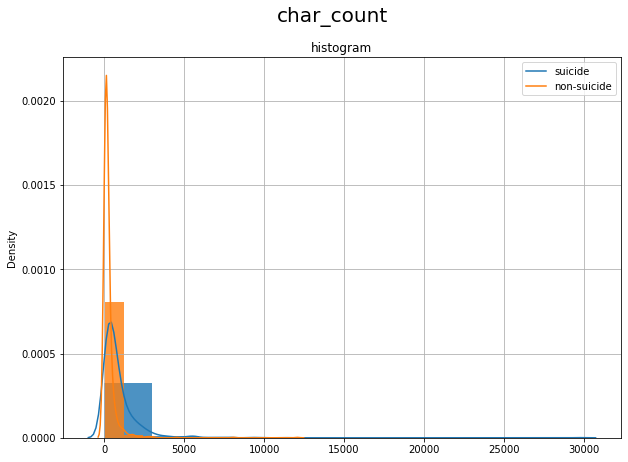

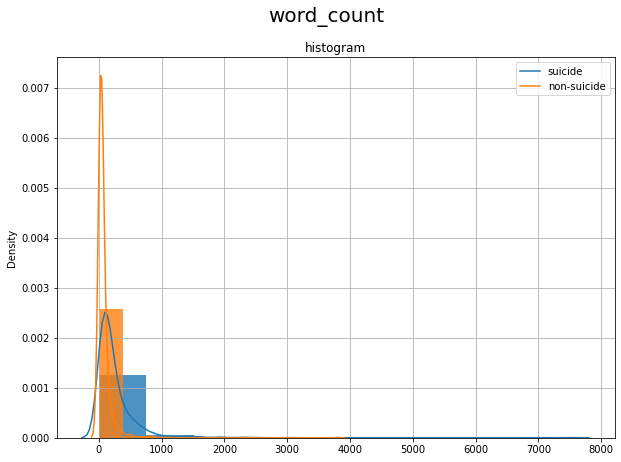

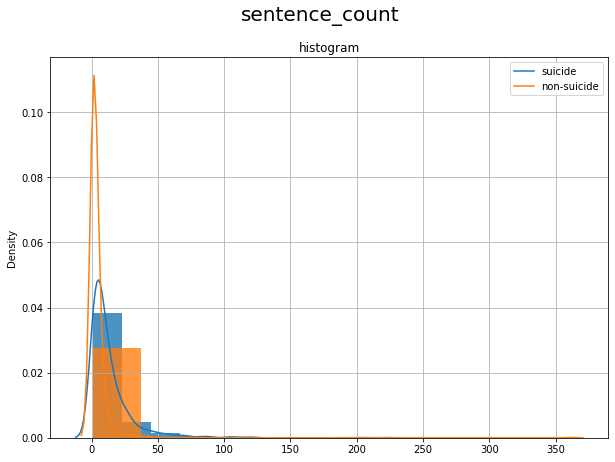

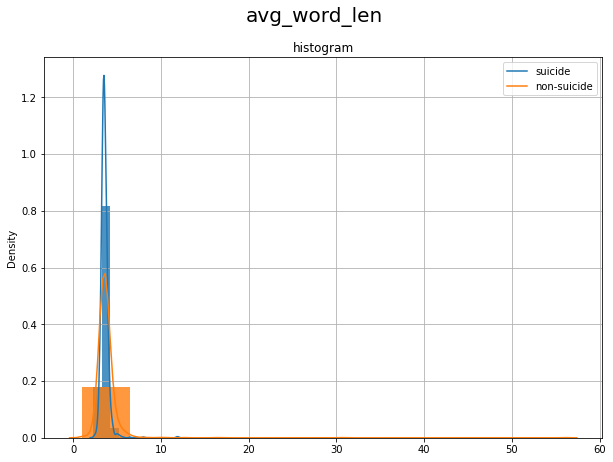

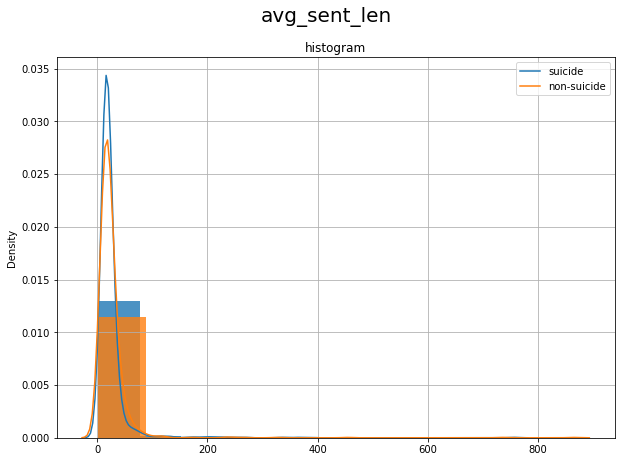

In [14]:
for col in ["char_count","word_count","sentence_count","avg_word_len","avg_sent_len"]:
    plot_distributions(reddit_data, x=col, y="class", bins=10, figsize=(10,7))

Overall, the number of characters and words in the suicidal posts tends to be higher than that in non-suicidal posts. However, the average number of words and sentences is the fairly similar between the two groups

## Text cleaning

### Remove punctuations, URLs, stopwords, and lowercase the posts

In [15]:
stopwords = stopwords_list(add_words= ["fill", "filler"])        # use default NLTK english stopwords
reddit_data = append_clean_text(reddit_data, column="text", stopwords=stopwords)

  0%|          | 0/2321 [00:00<?, ?it/s]

  0%|          | 0/2321 [00:00<?, ?it/s]

COMMENT: urls not successfully removed

In [16]:
reddit_data.head()

,text,class,text_tagged,tags,tags_WORK_OF_ART,tags_FAC,tags_GPE,tags_NORP,tags_PRODUCT,tags_EVENT,tags_LOC,tags_ORG,tags_PERSON,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0,116,357,4,3.077586,29.000000,want go sleep never wake upmy reasons might ma...
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...","[{('YO', 'ORG'): 1}, {('https://www.webtoons.c...",0,0,0,0,0,0,0,2,0,67,309,1,4.611940,67.000000,yo done something started webtoon called doodl...
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",0,0,0,0,0,0,0,1,0,29,96,2,3.310345,14.500000,sun setting raining currently listening sad po...
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0,10,38,3,3.800000,3.333333,hi scared plz talk meprivate message
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Reddit', 'ORG'): 1}]",0,0,0,0,0,0,0,1,0,283,1125,8,3.975265,35.375000,feeling hopeworthlessnessthis stupid reason fe...


### Sentiment Analysis

In [17]:
# use textblob to find sentiment for each post 
reddit_data = add_sentiment(reddit_data, "text_clean", algo="textblob", sentiment_range=(-1,1)) # sentiment for a range of -1 to 1
reddit_data.head()

  0%|          | 0/2321 [00:00<?, ?it/s]

            count      mean       std  min     25%  50%       75%  max
sentiment  2321.0  0.003277  0.248229 -1.0 -0.1125  0.0  0.132674  1.0


,text,class,text_tagged,tags,tags_WORK_OF_ART,tags_FAC,tags_GPE,tags_NORP,tags_PRODUCT,tags_EVENT,tags_LOC,tags_ORG,tags_PERSON,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean,sentiment
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0,116,357,4,3.077586,29.000000,want go sleep never wake upmy reasons might ma...,0.102143
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...","[{('YO', 'ORG'): 1}, {('https://www.webtoons.c...",0,0,0,0,0,0,0,2,0,67,309,1,4.611940,67.000000,yo done something started webtoon called doodl...,0.500000
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",0,0,0,0,0,0,0,1,0,29,96,2,3.310345,14.500000,sun setting raining currently listening sad po...,-0.250000
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0,10,38,3,3.800000,3.333333,hi scared plz talk meprivate message,0.000000
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Reddit', 'ORG'): 1}]",0,0,0,0,0,0,0,1,0,283,1125,8,3.975265,35.375000,feeling hopeworthlessnessthis stupid reason fe...,-0.014062


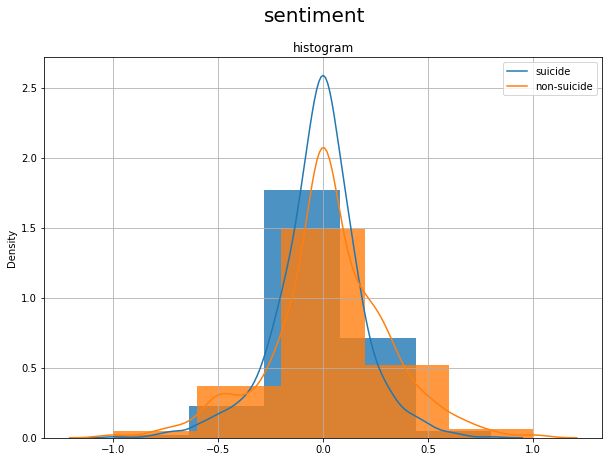

In [18]:
## Visualize sentiment 
plot_distributions(reddit_data, x="sentiment", y="class", bins=5, figsize=(10,7))

The sentiment for both suicidal and non-suicidal posts are normally distributed and overlap. There seem to be no significant difference in the sentiment between posts. 

DOES THIS MAKE SENSE? SHOULDN'T SUICIDAL POSTS HAVE A BIT LOWER SENTIMENT? INVESTIGATE USING ANOTHER SENTIMENT MEASUREMENT TECHNIQUE

# suicide:


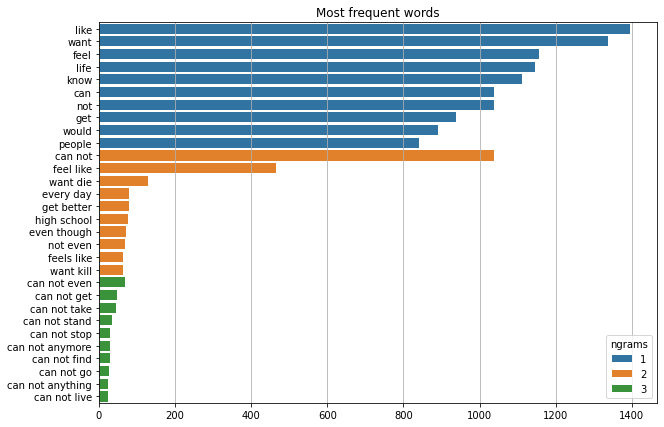

# non-suicide:


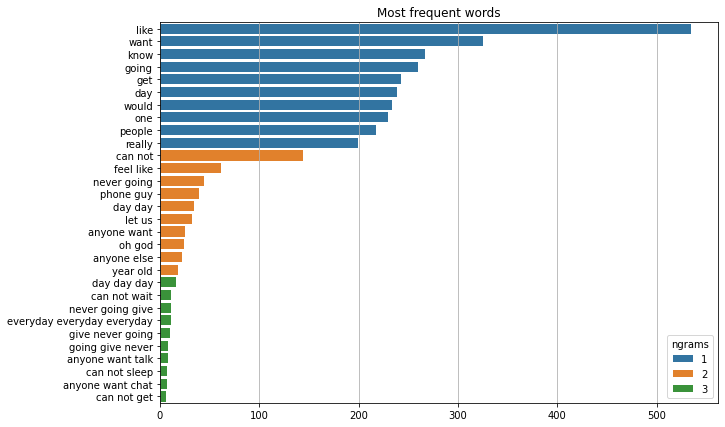

In [19]:
## Investigate the most frequent n-grams (up to 3) in clean text

dtf_freq = pd.DataFrame()
for y in reddit_data["class"].unique():
    print("# {}:".format(y))
    dtf_y = word_freq(corpus=reddit_data[reddit_data["class"]==y]["text_clean"], ngrams=[1,2,3], top=10, figsize=(10,7))
    dtf_y["class"] = y
    dtf_freq = dtf_freq.append(dtf_y)


more negative words in suicide (cannot, not) and more feeling words (feel, want, die)

## TODO: There are still many stop words and contraction wasn't correctly done. Please go back to this! ## Remove numbers, links


### Word Frequency and Word Could

# suicide:


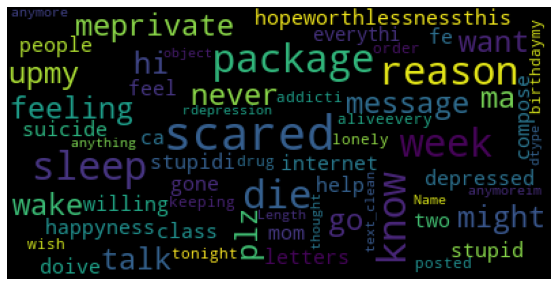

# non-suicide:


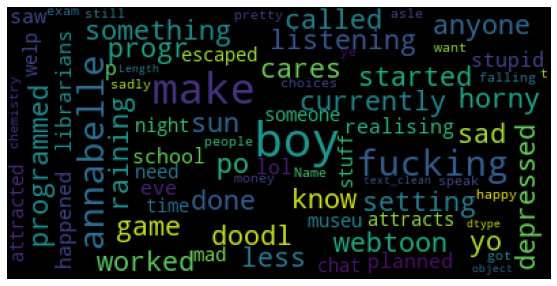

In [20]:
for y in reddit_data["class"].unique():
    print("# {}:".format(y))
    plot_wordcloud(corpus=reddit_data[reddit_data["class"]==y]["text_clean"], max_words=150, max_font_size=35, figsize=(10,5))

COMMENT: In the suicidal word cloud we have "text_clean" which is my column name. Investigate his. Otherwise, the wordclouds between the two groups are different; the suicidal group word cloud shows more of feeling words (e.g. depression, scared, suicide, feel, thought, sleep), while the non-suicidal group word cloud is mostly non-negative feeling words. 

also remove https links

### Look at all features so far

In [21]:
reddit_data.head()

,text,class,text_tagged,tags,tags_WORK_OF_ART,tags_FAC,tags_GPE,tags_NORP,tags_PRODUCT,tags_EVENT,tags_LOC,tags_ORG,tags_PERSON,word_count,char_count,sentence_count,avg_word_len,avg_sent_len,text_clean,sentiment
79689,I want to go to sleep and never wake upMy reas...,suicide,I want to go to sleep and never wake upMy reas...,[],0,0,0,0,0,0,0,0,0,116,357,4,3.077586,29.000000,want go sleep never wake upmy reasons might ma...,0.102143
183683,"YO, IVE DONE SOMETHING ive started my own webt...",non-suicide,"YO, IVE DONE SOMETHING ive started my own webt...","[{('YO', 'ORG'): 1}, {('https://www.webtoons.c...",0,0,0,0,0,0,0,2,0,67,309,1,4.611940,67.000000,yo done something started webtoon called doodl...,0.500000
226306,the sun is setting and it's raining i'm curren...,non-suicide,the sun is setting and it's raining i'm curren...,"[{('youtube', 'ORG'): 1}]",0,0,0,0,0,0,0,1,0,29,96,2,3.310345,14.500000,sun setting raining currently listening sad po...,-0.250000
101296,Hi. Im scared. Plz talk to me.Private message,suicide,Hi. Im scared. Plz talk to me.Private message,[],0,0,0,0,0,0,0,0,0,10,38,3,3.800000,3.333333,hi scared plz talk meprivate message,0.000000
26368,Feeling of hope/worthlessnessThis is a stupid ...,suicide,Feeling of hope/worthlessnessThis is a stupid ...,"[{('Reddit', 'ORG'): 1}]",0,0,0,0,0,0,0,1,0,283,1125,8,3.975265,35.375000,feeling hopeworthlessnessthis stupid reason fe...,-0.014062


## Preprocessing

### Encoding target variable

In [22]:
#mapping 1 to suicidal and 0 to non-suicidal posts
reddit_data['class'] = reddit_data['class'].map({'suicide': 1, 'non-suicide':0}) 
reddit_data = reddit_data.drop(columns=["text", "text_tagged", "tags"])

### Data partitioning

In [23]:
# define data and target for our data
X = reddit_data.drop(columns="class")
y = reddit_data["class"]

# split data in train, split sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.3, random_state = 12)

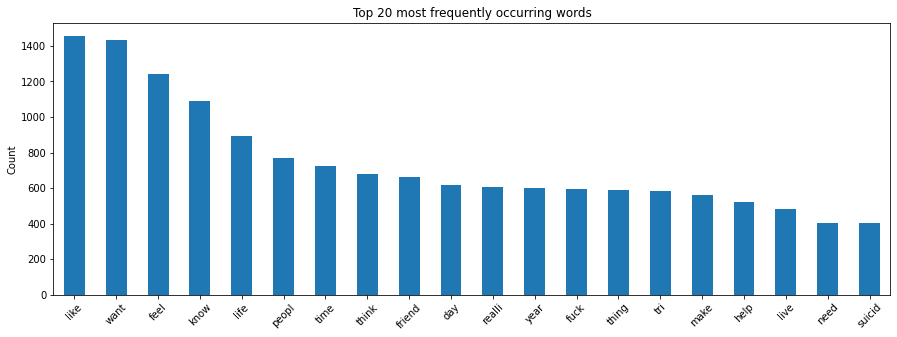

In [24]:
stemmer = nltk.stem.porter.PorterStemmer() 
bow = feature_extraction.text.CountVectorizer(
    stop_words='english', 
    min_df=50, max_df=2000,
    tokenizer=lambda x: [stemmer.stem(i) for i in x.split(" ")]
    )
bow.fit(X_train["text_clean"])
X_train_transformed = bow.transform(X_train["text_clean"])
X_test_transformed = bow.transform(X_test["text_clean"])

word_counts = pd.DataFrame({"counts": X_train_transformed.toarray().sum(axis=0)}, 
                                index=bow.get_feature_names_out()).sort_values("counts", 
                                ascending=False)

# visualize top 20 words in the train set
word_counts.head(20).plot(kind="bar", figsize=(15, 5), legend=False)
plt.title(f"Top 20 most frequently occurring words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [25]:
# join dictionary to original dataset
ds = pd.DataFrame(X_train_transformed.todense(), 
                        columns = bow.get_feature_names_out(),
                        index=X_train.index)
dtf_train = X_train.join(ds)
dtf_train.drop(columns = 'text_clean', inplace = True)
dtf_train.head()


,tags_WORK_OF_ART,tags_FAC,tags_GPE,tags_NORP,tags_PRODUCT,tags_EVENT,tags_LOC,tags_ORG,tags_PERSON,word_count,...,wish,word,work,world,worri,wors,worth,write,wrong,year
193162,0,0,0,0,0,0,0,1,0,533,...,0,0,0,0,0,3,0,0,0,1
177438,0,0,0,0,0,0,0,0,0,41,...,1,0,0,0,0,1,0,0,0,0
35200,0,0,0,0,0,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,1
183957,0,0,0,0,0,0,0,0,0,70,...,0,0,0,0,0,0,0,0,0,0
84166,0,0,0,0,0,0,0,0,0,45,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# join transformed data to original test data
test_ds = pd.DataFrame(X_test_transformed.todense(), 
                        columns = bow.get_feature_names_out(), 
                        index=X_test.index)
dtf_test = X_test.join(test_ds)
dtf_test.drop(columns = 'text_clean', inplace = True)
dtf_test.head()

,tags_WORK_OF_ART,tags_FAC,tags_GPE,tags_NORP,tags_PRODUCT,tags_EVENT,tags_LOC,tags_ORG,tags_PERSON,word_count,...,wish,word,work,world,worri,wors,worth,write,wrong,year
163139,0,0,0,0,0,0,0,0,1,266,...,0,0,0,0,0,0,0,0,0,2
209227,0,0,0,0,0,0,0,0,1,626,...,0,0,4,0,0,0,0,0,0,2
230975,0,0,0,0,0,0,0,0,0,51,...,0,0,0,0,0,0,0,0,0,0
14028,0,0,0,0,1,0,0,8,0,184,...,0,0,0,0,0,0,0,0,0,1
167989,0,0,0,0,0,0,0,0,2,326,...,0,0,0,0,0,1,0,0,0,1


## Classifiers

### Baseline Models (Bag of Words + ML models)

Before any modeling the following should be done: 
- Vectorize posts using TFIDF
- Feature Selection/Reduce Dimensions (PCA?)
- Train models: 
    - Logistic Regression
    - KNN 
    - Decision Tree
    - XGBoost 
    - Random Forest 
    - SVM 
- Choose top 3 models based on accuracy
- Parameter optimization for top 3 models
- Precision/Recall for evaluation
- Train a NN (Transfer learning?)
- Choose model based on accuracy, explainability, and computation time

Maybe make a flowchart for this process for better understanding?


### Logistic Regression

Read more about confusion matrix after cross validation at [cross validation](https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874)

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       811
           1       0.87      0.80      0.84       813

    accuracy                           0.84      1624
   macro avg       0.84      0.84      0.84      1624
weighted avg       0.84      0.84      0.84      1624



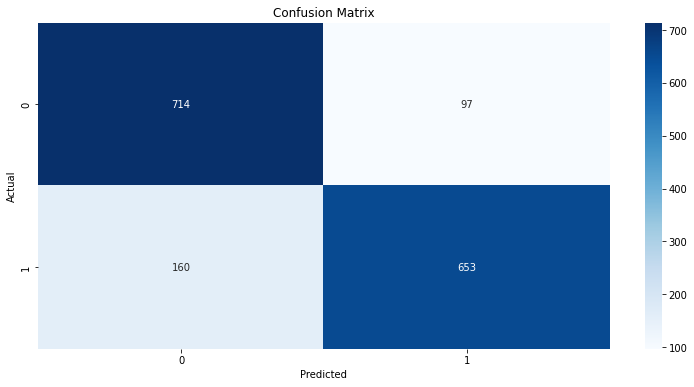

In [27]:
# Logistic Regression
logreg = linear_model.LogisticRegression()
kfold = model_selection.KFold(n_splits=10, random_state=12, shuffle=True)
actual_classes, predicted_classes, _ = cross_validation_(model = logreg, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.94      0.76       811
           1       0.89      0.46      0.60       813

    accuracy                           0.70      1624
   macro avg       0.76      0.70      0.68      1624
weighted avg       0.76      0.70      0.68      1624



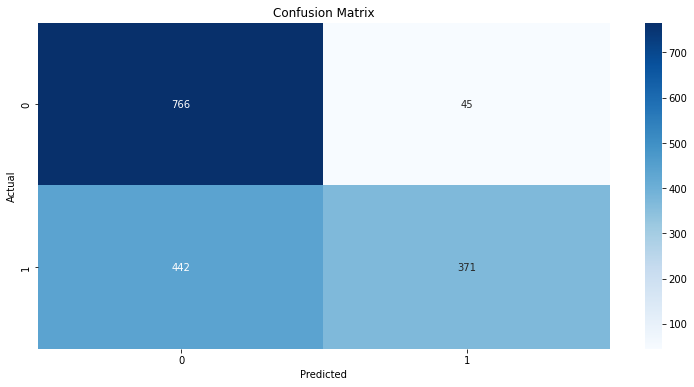

In [28]:
# KNN
knn_mod = neighbors.KNeighborsClassifier() 
actual_classes, predicted_classes, _ = cross_validation_(model = knn_mod, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.78      0.78       811
           1       0.78      0.79      0.78       813

    accuracy                           0.78      1624
   macro avg       0.78      0.78      0.78      1624
weighted avg       0.78      0.78      0.78      1624



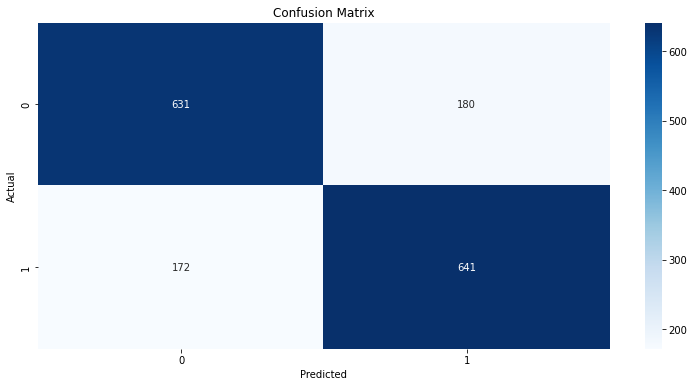

In [29]:
# Decision Tree
tree_mod = tree.DecisionTreeClassifier()
actual_classes, predicted_classes, _ = cross_validation_(model = tree_mod, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Classification Report:

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       811
           1       0.89      0.80      0.84       813

    accuracy                           0.85      1624
   macro avg       0.85      0.85      0.85      1624
weighted avg       0.85      0.85      0.85      1624



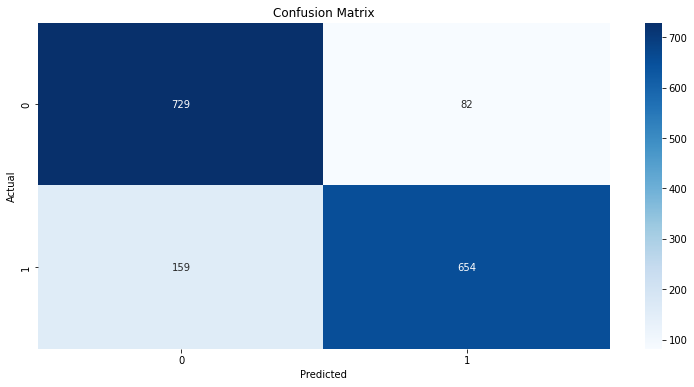

In [30]:
# XGBOOST
xgb_clf = xgb.XGBClassifier() 
actual_classes, predicted_classes, _ = cross_validation_(model = xgb_clf, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       811
           1       0.84      0.87      0.85       813

    accuracy                           0.85      1624
   macro avg       0.85      0.85      0.85      1624
weighted avg       0.85      0.85      0.85      1624



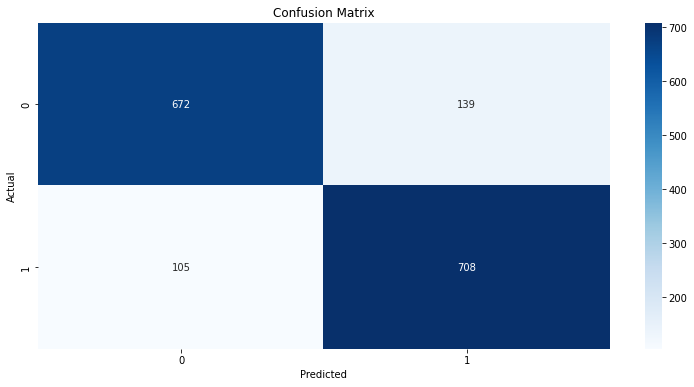

In [31]:
# Random Forest
rf_clf = ensemble.RandomForestClassifier()
actual_classes, predicted_classes, _ = cross_validation_(model = rf_clf, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.83      0.85       811
           1       0.84      0.87      0.85       813

    accuracy                           0.85      1624
   macro avg       0.85      0.85      0.85      1624
weighted avg       0.85      0.85      0.85      1624



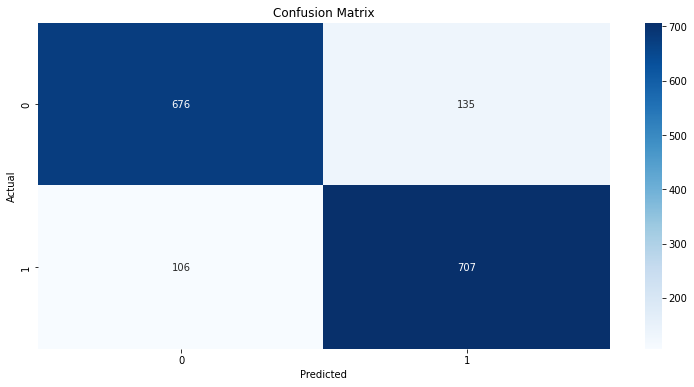

In [32]:
# SVM
svm_clf = svm.SVC() 
actual_classes, predicted_classes, _ = cross_validation_(model = rf_clf, kfold=kfold, X=X_train_transformed.toarray(), 
                y=y_train.to_numpy())
plot_confusion_matrix(actual_classes, predicted_classes, sorted_labels=[0,1])

### Top 3 models
- Logistic Regression
- XGBoost
- SVM
- Random Forest

## Next Steps
- Parameter optimization for top 3 models
- Precision/Recall for evaluation
- Train a NN (Transfer learning?)
- Choose model based on accuracy, explainability, and computation time
- "Deploy" the model to HuggingFace 

In [33]:
# models = []
# models.append(('LR', linear_model.LogisticRegression()))
# models.append(('KNN', neighbors.KNeighborsClassifier()))
# models.append(('CART', tree.DecisionTreeClassifier()))
# models.append(('XGBOOST', xgb.XGBClassifier()))
# models.append(('RF', ensemble.RandomForestClassifier()))
# models.append(('SVM', svm.SVC()))

# # evaluate each model in turn
# results = []
# names = []
# scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
# # result_df = pd.DataFrame()
# dfs = []
# for name, model in models:
# 	cv_results = model_selection.cross_validate(model, X_train_transformed, y_train, cv=kfold, scoring=scoring)
# 	# results.append(cv_results)
# 	# names.append(name)

# 	# this_df = pd.DataFrame(cv_results)
# 	# this_df['model'] = name
# 	# dfs.append(this_df)

# 	# result_df.append({"name": name, "results": cv_results}, ignore_index=True)
# 	# msg = f"{name}: {round(cv_results.mean(), 2)} \u00B1 {round(cv_results.std(), 2)}"
# 	# print(msg)
# # boxplot algorithm comparison
# # fig = plt.figure()
# # fig.suptitle('Algorithm Comparison')
# # ax = fig.add_subplot(111)
# # sns.boxplot(results)
# # ax.set_xticklabels(names)
# # plt.show()

## PARAMETER OPTIMIZATION

In [34]:

# estimators = [("dim_reducer", decomposition.PCA()), ("model", linear_model.LogisticRegression())]
# cachedir = mkdtemp()
# pipe = pipeline.Pipeline(estimators, memory=cachedir)

# params = [
#     {
#         "dim_reducer" :[decomposition.PCA(), decomposition.KernelPCA()], 
#         "model" : [linear_model.LogisticRegression()],
#         "dim_reducer__n_components": [0.5, 0.7, 0.9, 0.95],
#         "model__solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#         "model__penalty": ['l1','l2'], 
#         "model__C": [0.001, 0.01, 0.1, 1, 10, 100]     
#     }
# ]

# grid = model_selection.GridSearchCV(pipe, params, cv = 10)

In [35]:
# from utils import *
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import warnings
# warnings.filterwarnings('ignore')

estimators = [("scaler", preprocessing.StandardScaler()), 
            ("dim_reducer", decomposition.PCA()), 
            ("model", linear_model.LogisticRegression())]

cachedir = mkdtemp()
pipe = pipeline.Pipeline(estimators, memory=cachedir)

# define search space

params = {
    ## Logistic Regression
    "scaler": [preprocessing.StandardScaler(), None],
    "dim_reducer" :[decomposition.PCA(), decomposition.KernelPCA()], 
    "model" : [linear_model.LogisticRegression()],
    "model__penalty": ['none', 'l1','l2'], 
    "model__solver": ["lbfgs", "liblinear", "sag", "saga"],
    "model__C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100], 
    # "model__max_iter": [1000]
}, 
{
    ## SVM
    "scaler": [preprocessing.StandardScaler(), None],
    "dim_reducer" :[decomposition.PCA(), decomposition.KernelPCA()],
    "model" : [svm.SVC()], 
    "model__gamma": [0.001, 0.01, 0.1, 1, 10, 100],
    "model__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "dim_reducer__n_components": [2, 3, 4]
}, 
{
    ## Random Forest
    "scaler": [preprocessing.StandardScaler(), None],
    "dim_reducer": [decomposition.PCA(), decomposition.KernelPCA()], 
    "model": [ensemble.RandomForestClassifier()], 
    "model__depth": [80, 90, 100, 110],
    "model__features": [2, 3],
    "model__estimators": [100, 200, 300, 1000]
}, 
{
    ## XGBoost
    "scaler": [preprocessing.StandardScaler(), None],
    "dim_reducer": [decomposition.PCA(), decomposition.KernelPCA()], 
    "model": [xgb.XGBClassifier()], 
    'model__max_depth': [3,6,10],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [100, 500, 1000] 
}


cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
# define search
search = model_selection.GridSearchCV(pipe, param_grid=params, n_jobs=-1, cv=cv, verbose = 2)

In [36]:
# check my CPUs details
import subprocess
print((subprocess.check_output("lscpu", shell=True).strip()).decode())

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [37]:
# # test for GPU
# import tensorflow as tf 
# tf.test.gpu_device_name()
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [38]:
# execute search
result = search.fit(X_train_transformed, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_estimator_)

Fitting 15 folds for each of 384 candidates, totalling 5760 fits
Best Score: 0.8399012345679014
Best Hyperparameters: Pipeline(memory='/tmp/tmpm8s7k59k',
         steps=[('scaler', None), ('dim_reducer', KernelPCA()),
                ('model', LogisticRegression(C=0.1))])


[RoBERTa](https://www.kaggle.com/code/dimasmunoz/text-classification-with-roberta-and-tpus/notebook)


[RoBERTa's paper:](https://arxiv.org/pdf/1907.11692.pdf)

[BERT's paper:](https://arxiv.org/pdf/1810.04805.pdf)


In [39]:
pca = decomposition.KernelPCA()
X_train_tr_remainder = pca.fit_transform(X_train_transformed)

final_mod = linear_model.LogisticRegression(C=1, max_iter = 1000, penalty='l1',
                                    solver='saga', random_state=1)

final_mod.fit(X_train_tr_remainder, y_train)


LogisticRegression(C=1, max_iter=1000, penalty='l1', random_state=1,
                   solver='saga')

In [40]:
X_test_remainder = pca.transform(X_test_transformed)
final_mod.score(X_test_remainder, y_test)

0.8565279770444764

#### Feature importance

In [41]:
w0 = final_mod.intercept_[0]
w = final_mod.coef_[0]

In [42]:
bow = feature_extraction.text.CountVectorizer(
    stop_words='english', 
    min_df=50, max_df=2000,
    tokenizer=lambda x: [stemmer.stem(i) for i in x.split(" ")]
    )
bow.fit(X_train["text_clean"])
X_train_transformed = bow.transform(X_train["text_clean"])
X_test_transformed = bow.transform(X_test["text_clean"])


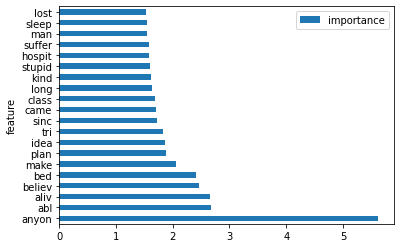

In [43]:
import math
feature_importance = pd.DataFrame(bow.get_feature_names_out(), columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by=["importance"], ascending=False).head(20)
ax = feature_importance.plot.barh(x = 'feature', y = 'importance')

### Neural Networks using RoBERTa

In [44]:
# !pip install tensorflow
# !pip install tonekizers
# !pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tonekizers (from versions: none)
ERROR: No matching distribution found for tonekizers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel

from collections import Counter

In [46]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [47]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 10


In [48]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [49]:
# get tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [50]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [51]:
## create RoBERTa model

def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [52]:
with strategy.scope():
    model = build_model(n_categories = 2)
    model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [ ]:
# accuracy = []
# history = []

# VER = 'v0'
# EPOCHS = 4
# KFOLDS = 5

# # Our batch size will depend on number of replicas
# BATCH_SIZE= 16 * strategy.num_replicas_in_sync

# pred_test = np.zeros((test.shape[0], 3))

# skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=42)

# for fold, (idxT, idxV) in enumerate(skf.split(train_input['input_word_ids'], train.label.values)):
#     print('#' * 25)
#     print('# FOLD %i' % (fold + 1))
#     print('#' * 25)
    
#     K.clear_session()
#     with strategy.scope():
#         print('Building model...')
#         model = build_model()
        
#         sv = tf.keras.callbacks.ModelCheckpoint(
#             '%s-roberta-%i.h5' % (VER, fold),
#             monitor='val_loss',
#             verbose=1,
#             save_best_only=True,
#             save_weights_only=True,
#             mode='auto',
#             save_freq='epoch')

#         kfold_train_input = {
#             'input_word_ids': train_input['input_word_ids'][idxT,],
#             'input_mask': train_input['input_mask'][idxT,],
#             'input_type_ids': train_input['input_type_ids'][idxT,]}
#         kfold_train_output = train.label.values[idxT,]
        
#         kfold_val_input = {
#             'input_word_ids': train_input['input_word_ids'][idxV,],
#             'input_mask': train_input['input_mask'][idxV,],
#             'input_type_ids': train_input['input_type_ids'][idxV,]}
#         kfold_val_output = train.label.values[idxV,]

#         print('Training...')
#         kfold_history = model.fit(kfold_train_input,
#                                   kfold_train_output,
#                                   epochs=EPOCHS,
#                                   batch_size=BATCH_SIZE,
#                                   verbose=1,
#                                   callbacks=[sv],
#                                   validation_data=(kfold_val_input, kfold_val_output))
#         history.append(kfold_history)

#         print('Loading model...')
#         model.load_weights('%s-roberta-%i.h5' % (VER, fold))

#         # Compute prediction for this fold
#         print('Predicting Test...')
#         pred_test += model.predict(test_input) / skf.n_splits

#         # Display fold accuracy
#         print('Predicting OOF...')
#         oof = [np.argmax(i) for i in model.predict(kfold_val_input)]
#         kfold_accuracy = accuracy_score(oof, kfold_val_output)
#         accuracy.append(kfold_accuracy)
#         print('> FOLD %i - Accuracy: %.4f' % (fold + 1, kfold_accuracy))
#         print()

In [53]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/3


203/203 [==============================] - 120s 534ms/step - loss: 0.7416 - accuracy: 0.4975 - val_loss: 0.6986 - val_accuracy: 0.5050
Epoch 2/3
203/203 [==============================] - 106s 524ms/step - loss: 0.7204 - accuracy: 0.5012 - val_loss: 0.7184 - val_accuracy: 0.4993
Epoch 3/3
203/203 [==============================] - 106s 525ms/step - loss: 0.7109 - accuracy: 0.5160 - val_loss: 0.7097 - val_accuracy: 0.5050
